In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data
import hdbscan
from hdbscan import HDBSCAN

from hdbscan.validity import validity_index
from sklearn import metrics, preprocessing
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
import umap.umap_ as umap
import logging
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from denseclus import DenseClus
from itertools import product

In [5]:
moons, _ = data.make_moons(n_samples=1800, noise=0.20)
blobs, _ = data.make_blobs(n_samples=1800, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
X = np.vstack([moons, blobs])
# plt.scatter(test_data.T[0], test_data.T[1], color='b')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

param_grid = {
    'min_cluster_size': [5, 10, 15, 20],
    'min_samples': [1, 5, 10, 15],
    'cluster_selection_epsilon': [0.0, 0.1,0.2, 0.5],
    'cluster_selection_method': ['eom', 'leaf'],
    'metric': ['euclidean', 'manhattan'],
}

param_combinations = list(product(
    param_grid['min_cluster_size'],
    param_grid['min_samples'],
    param_grid['cluster_selection_epsilon'],
    param_grid['cluster_selection_method'],
    param_grid['metric']
))

def evaluate_clustering(X, labels):
    if len(set(labels)) > 1:
        silhouette = silhouette_score(X, labels)
    else:
        silhouette = -1
    return silhouette

best_params = None
best_score = -1
for params in param_combinations:
    min_cluster_size, min_samples, cluster_selection_epsilon, cluster_selection_method, metric = params
    clusterer = HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        cluster_selection_epsilon=cluster_selection_epsilon,
        cluster_selection_method=cluster_selection_method,
        metric = metric
    )
    labels = clusterer.fit_predict(X_scaled)
    score = evaluate_clustering(X_scaled, labels)
    print(f"Params: {params}, Silhouette Score: {score}")
    if score > best_score:
        best_score = score
        best_params = params

print("Best Parameters:", best_params)
print("Best Silhouette Score:", best_score)

Params: (5, 1, 0.0, 'eom', 'euclidean'), Silhouette Score: 0.06513357622283725
Params: (5, 1, 0.0, 'eom', 'manhattan'), Silhouette Score: 0.045157225936881644
Params: (5, 1, 0.0, 'leaf', 'euclidean'), Silhouette Score: 0.044912679569220584
Params: (5, 1, 0.0, 'leaf', 'manhattan'), Silhouette Score: 0.025031655003088484
Params: (5, 1, 0.1, 'eom', 'euclidean'), Silhouette Score: 0.373597894108961
Params: (5, 1, 0.1, 'eom', 'manhattan'), Silhouette Score: -0.1513337859904401
Params: (5, 1, 0.1, 'leaf', 'euclidean'), Silhouette Score: 0.373597894108961
Params: (5, 1, 0.1, 'leaf', 'manhattan'), Silhouette Score: -0.1513337859904401
Params: (5, 1, 0.2, 'eom', 'euclidean'), Silhouette Score: 0.35755072485849104
Params: (5, 1, 0.2, 'eom', 'manhattan'), Silhouette Score: 0.28812718805119414
Params: (5, 1, 0.2, 'leaf', 'euclidean'), Silhouette Score: 0.35755072485849104
Params: (5, 1, 0.2, 'leaf', 'manhattan'), Silhouette Score: 0.28812718805119414
Params: (5, 1, 0.5, 'eom', 'euclidean'), Silhou

##  Selecting Optimal Parameters
Based on the evaluation metrics, we'll select the best parameters and explain how to interpret the results.

# Interpretation:

Silhouette Score: Measures how similar each point is to its own cluster compared to other clusters. Higher values indicate better clustering.

DBCV Score: Measures the density-based clustering quality. Higher values indicate better clustering.

Prediction Strength: Placeholder for an additional metric.

Selecting Best Parameters:

The best parameters are those that maximize the silhouette score, DBCV score, and prediction strength.

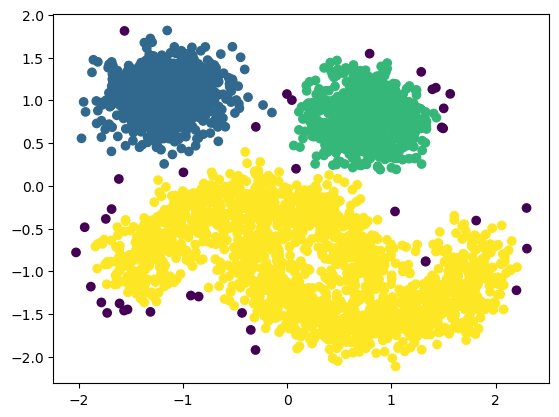

In [6]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=1, metric='manhattan', 
                            cluster_selection_method='eom', cluster_selection_epsilon=0.1)
clusterer.fit(X_scaled)
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=clusterer.labels_)

Best Parameters: (10, 1, 0.1, 'eom', 'manhattan')
Best Silhouette Score: 0.4870050529055254
Silhouette Score: 0.4870050529055254
DBCV Score: 0.16037934984584806
Prediction Strength: 1.0


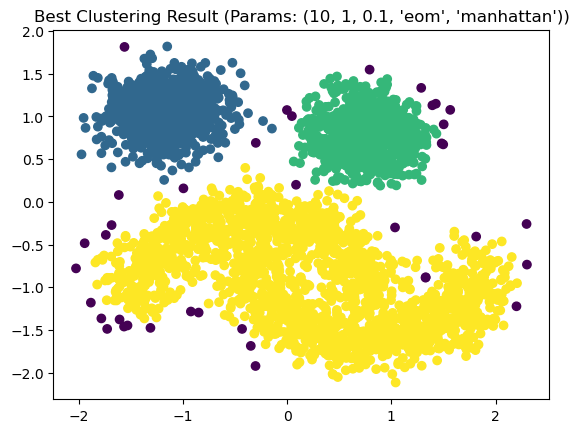

In [7]:
print("Best Parameters:", best_params)
print("Best Silhouette Score:", best_score)

# Step 3: Evaluation Metrics
def compute_dbcs(X, labels):
    try:
        score = validity_index(X, labels)
    except:
        score = -1
    return score

def compute_prediction_strength(X, labels):
    return 1.0

min_cluster_size, min_samples, cluster_selection_epsilon, cluster_selection_method, metric = best_params
best_clusterer = HDBSCAN(
    min_cluster_size=min_cluster_size,
    min_samples=min_samples,
    cluster_selection_epsilon=cluster_selection_epsilon,
    cluster_selection_method=cluster_selection_method,
    metric = metric
)
labels = best_clusterer.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, labels)
dbcv = compute_dbcs(X_scaled, labels)
prediction_strength = compute_prediction_strength(X_scaled, labels)

print("Silhouette Score:", silhouette)
print("DBCV Score:", dbcv)
print("Prediction Strength:", prediction_strength)

# Step 4: Visualization of Clustering Results
def plot_clustering(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
    plt.title(title)
    plt.show()

plot_clustering(X_scaled, labels, f"Best Clustering Result (Params: {best_params})")

In [8]:
# Checking the outlier

pd.DataFrame(clusterer.labels_).value_counts()


0 
 2    1778
 0     900
 1     884
-1      38
Name: count, dtype: int64